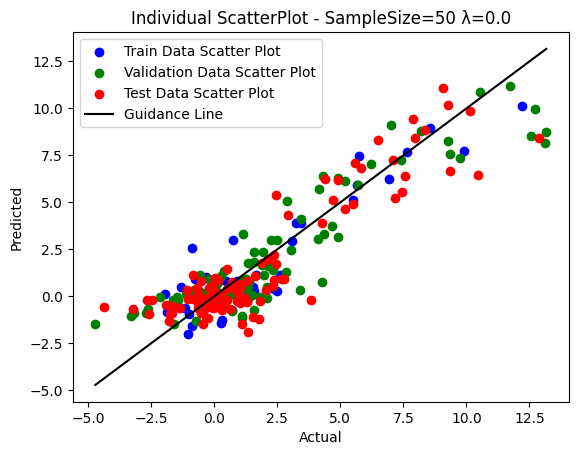

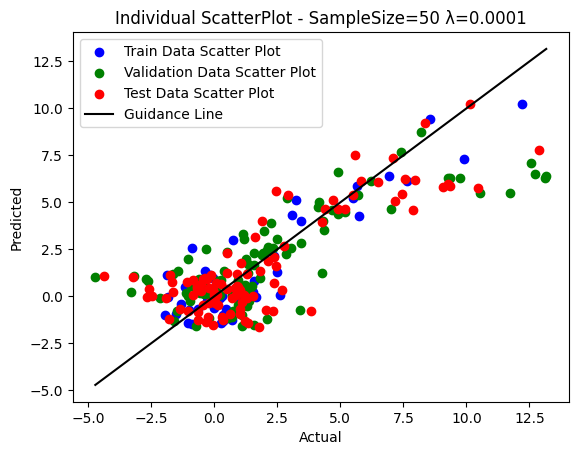

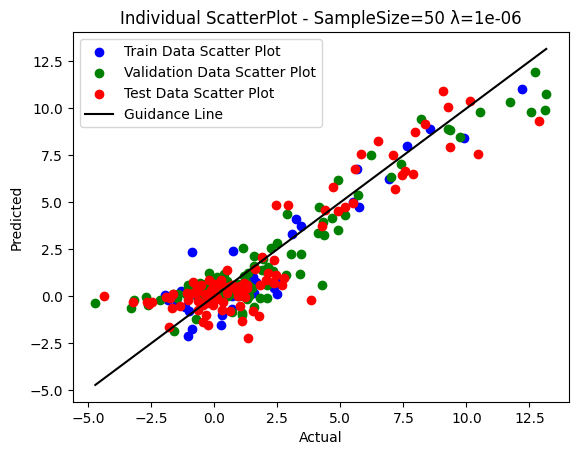

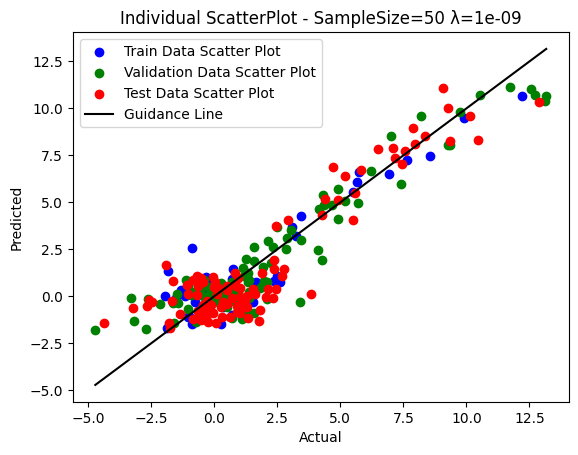

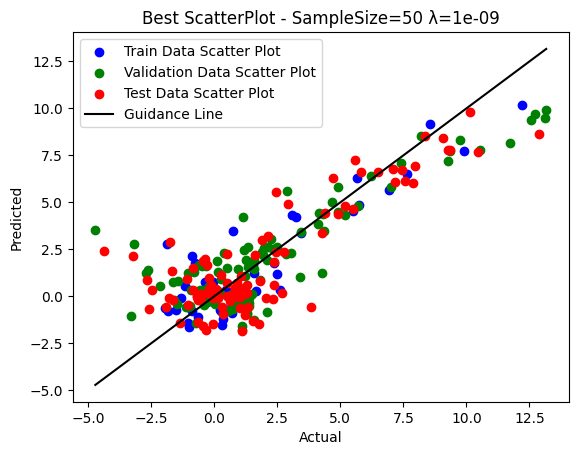

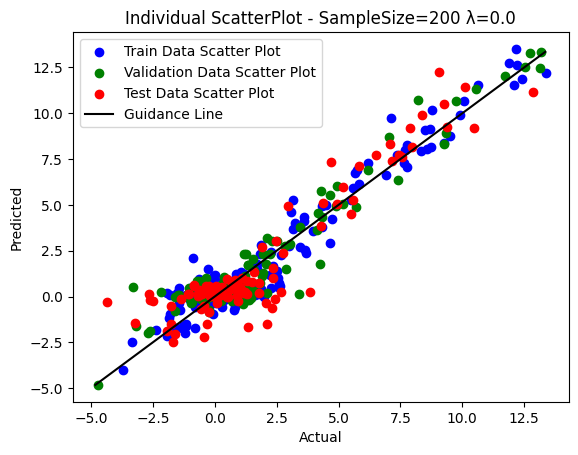

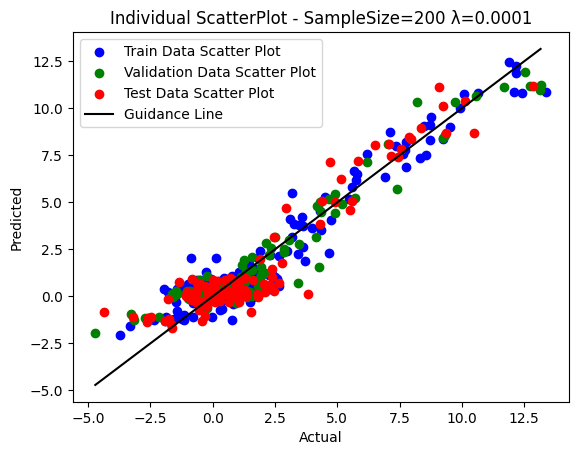

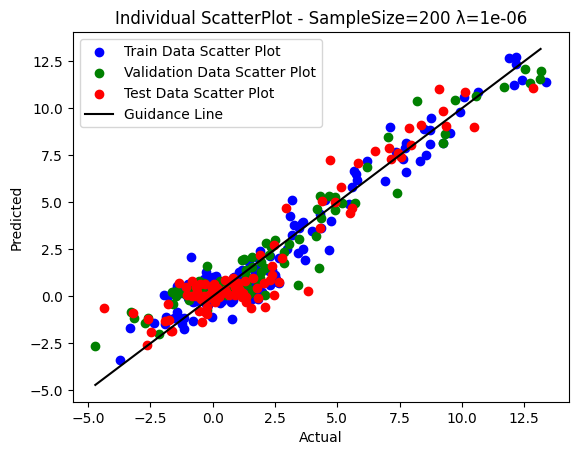

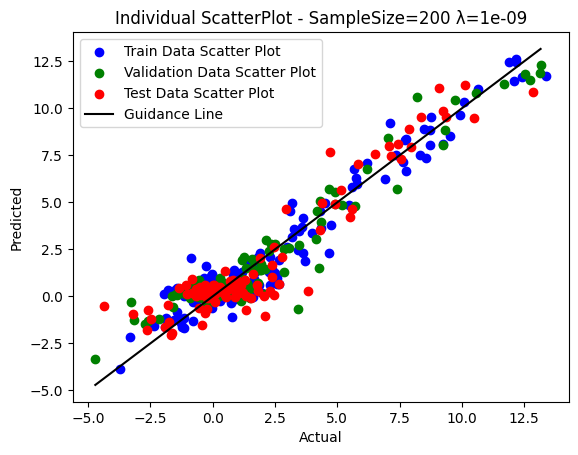

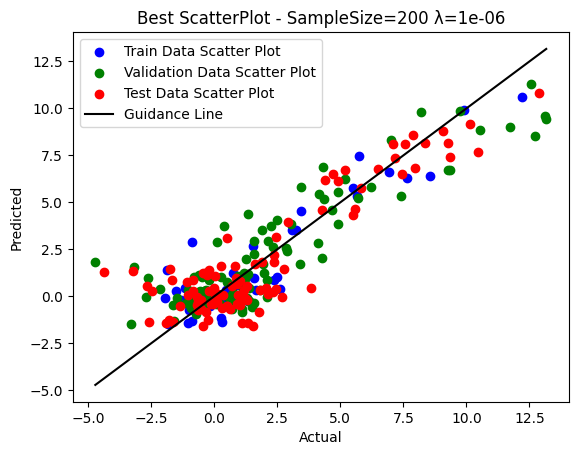

Index Sample Size            λ  Train Erms  Validate Erms  Test Erms
    1          50 0.000000e+00    1.364759       1.880082   1.708797
    2          50 1.000000e-04    1.449703       2.124841   1.784542
    3          50 1.000000e-06    1.044310       1.570486   1.452099
    4          50 1.000000e-09    0.977335       1.408410   1.403578
    5         200 0.000000e+00    0.890749       1.086751   1.277770
    6         200 1.000000e-04    0.984294       1.059920   1.171039
    7         200 1.000000e-06    0.931728       1.063459   1.158499
    8         200 1.000000e-09    0.910245       1.078568   1.200793


In [1]:
"""
Task 3. Dataset 2 
    Input -
        Datasets_for_A1 folder needs to be in the current working 
        directory with the folder structure as 
        Datasets_for_A1/Regression/Dataset 2/<team number>/
        Replace <team number> with the actual number.
        e.g. Datasets_for_A1/Regression/Dataset 2/9/
    Output -
        Linear model for regression using Gaussian basis functions for Datasets 2 and 3
        Regularization methods:
            1. No regularization
            2. Quadratic regularization
        Presentation of Results:
            • Scatter plots with target output on x-axis and model output on y-axis 
            for the best performing model, for training data and test data.
            • Tables showing the 𝐸𝑅𝑀𝑆 on the training data, the validation
            data and the test data, for different models.
"""

import os
import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

lambda_string = "λ"
column_names = [
    "Index",
    "Sample Size",
    "λ",
    "Train Erms",
    "Validate Erms",
    "Test Erms",
]
table_index = 0
table_df = pd.DataFrame(columns=column_names)


def add_data_to_table(sample_size, lamda, train_erms, validate_erms, test_erms):
    row_data = {}
    global table_df
    global table_index
    table_index = table_index + 1
    row_data["Index"] = table_index
    row_data["Sample Size"] = sample_size
    row_data["λ"] = lamda
    row_data["Train Erms"] = train_erms
    row_data["Validate Erms"] = validate_erms
    row_data["Test Erms"] = test_erms
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        table_df = pd.concat(
            [table_df, pd.DataFrame(row_data, index=[0])], ignore_index=True
        )


def print_table():
    print(table_df.to_string(index=False))


def get_N(x):
    N = len(x)
    return N


def get_identity_matrix(n):
    identity_matrix = np.eye(n)

    return identity_matrix


def estimate_sigma(x, centroids):
    sigma_list = []
    data = x
    N = data.shape[0]
    for loop in range(N):
        small_phi = []
        data_x = data[loop]
        for centroid in centroids:
            sum = np.square(np.linalg.norm(data_x - centroid, 2))
            sigma_list.append(sum)
    sigma_avg = np.average(sigma_list)

    return sigma_avg


def get_phi_by_gaussian(x, D):
    data = x
    cluster_count = D - 1

    indices = list(range(data.shape[0]))
    random.shuffle(indices)
    centroid_indices = indices[:cluster_count]
    centroid_indices = np.array(centroid_indices)

    centroids = data[centroid_indices]

    cluster_members = [[] for _ in range(cluster_count)]

    while True:
        distances = np.empty((data.shape[0], centroids.shape[0]))
        for i, point in enumerate(data):
            for j, centroid in enumerate(centroids):
                distance = np.linalg.norm(point - centroid, 2)
                distances[i, j] = distance

        labels = []

        for row in distances:
            min_distance = float("inf")
            min_index = -1
            for i, distance in enumerate(row):
                if distance < min_distance:
                    min_distance = distance
                    min_index = i
            labels.append(min_index)

        labels = np.array(labels)

        new_centroids = []

        for k in range(cluster_count):
            cluster_points = data[labels == k]
            if cluster_points.size == 0:
                centroids = np.array([])
                return centroids
            centroid = cluster_points.mean(axis=0)
            new_centroids.append(centroid)

        new_centroids = np.array(new_centroids)

        cluster_members = [[] for _ in range(cluster_count)]
        centroid_mapping = {tuple(centroid): [] for centroid in centroids}
        for i, label in enumerate(labels):
            cluster_members[label].append(data[i])
            centroid_mapping[tuple(centroids[label])].append(data[i])

        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids


def get_small_phi(data_x, centroids, sigma):
    small_phi = []
    for centroid in centroids:
        sum = np.square(np.linalg.norm(data_x - centroid, 2))
        sum = sum / sigma
        sum = np.exp(-sum)
        small_phi.append(sum)
    small_phi = np.insert(small_phi, 0, 1)

    return small_phi


def get_big_phi(x, centroids, sigma):
    big_phi = []
    data = x
    N = data.shape[0]
    for loop in range(N):
        data_x = data[loop]
        small_phi = get_small_phi(data_x, centroids, sigma)
        big_phi.append(small_phi)

    np_big_phi = np.array(big_phi)

    return np_big_phi


def get_new_y(w, big_phi, N, D):
    new_y = []
    loop1 = 0

    for loop1 in range(N):
        small_phi = big_phi[loop1]
        y = 0
        loop2 = 0
        for loop2 in range(D):
            wi = w[loop2]
            small_phii = small_phi[loop2]
            y = y + (wi * small_phii)
        new_y.append(y)
    np_new_y = np.array(new_y)
    return np_new_y


def get_erms(y, t):
    loop = 0
    total_data = len(y)
    sum = 0

    for loop in range(total_data):
        sum = sum + np.square(y[loop] - t[loop])

    error = sum / total_data

    erms = np.sqrt(error)

    return erms


def scatter_plot_2d(x, y, x_label, y_label, plot_title, plot_color):
    plt.scatter(x, y, color=plot_color, label=plot_title)
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()


def line_plot(x, y, plot_label, plot_color):
    plt.plot(x, y, color=plot_color, label=plot_label)
    plt.legend()


def get_least_erms(n):
    global table_df
    last_n_rows = table_df.tail(n)
    sorted_rows = last_n_rows.sort_values(by="Test Erms")
    first_sorted_row_values = sorted_rows.iloc[0].values
    return first_sorted_row_values


def plot_scatter(
    sample_size, lamda, train_x, train_y, val_x, val_y, test_x, test_y, title
):
    N = get_N(train_y)
    D = N * 0.2
    D = int(D)

    while True:
        centroids = get_phi_by_gaussian(train_x, D)
        if centroids.size != 0:
            break

    sigma = estimate_sigma(train_x, centroids)

    big_phi_train = get_big_phi(train_x, centroids, sigma)
    w = my_polyfit(big_phi_train, train_y, D, lamda)
    new_train_y = get_new_y(w, big_phi_train, N, D)
    plot_title = "Train Data Scatter Plot"
    scatter_plot_2d(train_y, new_train_y, "Actual", "Predicted", plot_title, "blue")

    N = get_N(val_y)
    big_phi_val = get_big_phi(val_x, centroids, sigma)
    new_val_y = get_new_y(w, big_phi_val, N, D)
    plot_title = "Validation Data Scatter Plot"
    scatter_plot_2d(val_y, new_val_y, "Actual", "Predicted", plot_title, "green")

    N = get_N(test_y)
    big_phi_test = get_big_phi(test_x, centroids, sigma)
    new_test_y = get_new_y(w, big_phi_test, N, D)
    plot_title = "Test Data Scatter Plot"
    scatter_plot_2d(test_y, new_test_y, "Actual", "Predicted", plot_title, "red")

    min_point = min(
        np.min(val_y), np.min(new_val_y), np.min(test_y), np.min(new_test_y)
    )
    max_point = max(
        np.max(val_y), np.max(new_val_y), np.max(test_y), np.max(new_test_y)
    )

    line_plot((min_point, max_point), (min_point, max_point), "Guidance Line", "black")

    plot_title = (
        title + "ScatterPlot - SampleSize=" + str(sample_size) + " λ=" + str(lamda)
    )
    plt.title(plot_title)
    current_directory = os.getcwd()
    os.makedirs(current_directory + "/reg_3", exist_ok=True)
    plt.savefig(current_directory + "/reg_3/" + plot_title + ".png")
    plt.show()


def my_pseudo_inverse(matrix):
    matrix_transpose = np.transpose(matrix)
    phi_trans_multi_phi = np.dot(matrix_transpose, matrix)
    phi_trans_multi_phi_inv = np.linalg.inv(phi_trans_multi_phi)
    phi_trans_multi_phi_inv_multi_phi_trans = np.dot(
        phi_trans_multi_phi_inv, matrix_transpose
    )

    return phi_trans_multi_phi_inv_multi_phi_trans


def my_pseudo_inverse_with_regularization(matrix, matrix_dimension, lamda):
    matrix_transpose = np.transpose(matrix)
    phi_trans_multi_phi = np.dot(matrix_transpose, matrix)
    Identity = get_identity_matrix(matrix_dimension)
    regularization_matrix = np.multiply(Identity, lamda)
    phi_trans_multi_phi_add_regularized = np.add(
        phi_trans_multi_phi, regularization_matrix
    )
    phi_trans_multi_phi_inv = np.linalg.inv(phi_trans_multi_phi_add_regularized)
    phi_trans_multi_phi_inv_multi_phi_trans = np.dot(
        phi_trans_multi_phi_inv, matrix_transpose
    )

    return phi_trans_multi_phi_inv_multi_phi_trans


def my_polyfit(big_phi, y, D, lamda=0.0):
    if lamda == 0.0:
        my_pseudo_inv_np_big_phi = my_pseudo_inverse(big_phi)
        pseudo_inv_np_big_phi = my_pseudo_inv_np_big_phi
    else:
        my_regularized_pseudo_inv_np_big_phi = my_pseudo_inverse_with_regularization(
            big_phi, D, lamda
        )
        pseudo_inv_np_big_phi = my_regularized_pseudo_inv_np_big_phi

    w = np.dot(pseudo_inv_np_big_phi, y)

    return w


def plot_graphs(train_x, train_y, title, val_x, val_y, test_x, test_y, lamda=0.0):

    N = get_N(train_y)
    sample_size = N
    D = N * 0.2
    D = int(D)

    while True:
        centroids = get_phi_by_gaussian(train_x, D)
        if centroids.size != 0:
            break

    sigma = estimate_sigma(train_x, centroids)

    big_phi_train = get_big_phi(train_x, centroids, sigma)
    w = my_polyfit(big_phi_train, train_y, D, lamda)

    new_train_y = get_new_y(w, big_phi_train, N, D)
    train_erms = get_erms(new_train_y, train_y)

    N = get_N(val_y)
    big_phi_val = get_big_phi(val_x, centroids, sigma)
    new_val_y = get_new_y(w, big_phi_val, N, D)
    validate_erms = get_erms(new_val_y, val_y)

    N = get_N(test_y)
    big_phi_test = get_big_phi(test_x, centroids, sigma)
    new_test_y = get_new_y(w, big_phi_test, N, D)
    test_erms = get_erms(new_test_y, test_y)

    add_data_to_table(sample_size, lamda, train_erms, validate_erms, test_erms)

    min_erms = get_least_erms(1)
    plot_scatter(
        min_erms[1],
        min_erms[2],
        train_x,
        train_y,
        val_x,
        val_y,
        test_x,
        test_y,
        "Individual ",
    )


def main():
    folder_number = "18"
    current_directory = os.getcwd()
    regression_dataset_2_path = (
        current_directory
        + "/Datasets_for_A1/Regression/Dataset 2/"
        + folder_number
        + "/"
    )

    regression_dataset_2_Train_Sample_1 = (
        regression_dataset_2_path + "train50_" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_Train_Sample_1)
    data = df.to_numpy()
    train_x_1 = data[:, :2]
    train_y_1 = data[:, 2]

    regression_dataset_2_Train_Sample_2 = (
        regression_dataset_2_path + "train200_" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_Train_Sample_2)
    data = df.to_numpy()
    train_x_2 = data[:, :2]
    train_y_2 = data[:, 2]

    regression_dataset_2_validation = (
        regression_dataset_2_path + "val_" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_validation)
    data = df.to_numpy()
    val_x = data[:, :2]
    val_y = data[:, 2]

    regression_dataset_2_test = (
        regression_dataset_2_path + "test_" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_test)
    data = df.to_numpy()
    test_x = data[:, :2]
    test_y = data[:, 2]

    regularization_coefficients = [0.0, 0.0001, 1e-6, 1e-9]

    for lamda in regularization_coefficients:
        plot_graphs(
            train_x_1,
            train_y_1,
            "train50_" + folder_number,
            val_x,
            val_y,
            test_x,
            test_y,
            lamda,
        )

    min_erms = get_least_erms(len(regularization_coefficients))
    plot_scatter(
        min_erms[1],
        min_erms[2],
        train_x_1,
        train_y_1,
        val_x,
        val_y,
        test_x,
        test_y,
        "Best ",
    )

    for lamda in regularization_coefficients:
        plot_graphs(
            train_x_2,
            train_y_2,
            "train200_" + folder_number,
            val_x,
            val_y,
            test_x,
            test_y,
            lamda,
        )
    min_erms = get_least_erms(len(regularization_coefficients))
    plot_scatter(
        min_erms[1],
        min_erms[2],
        train_x_1,
        train_y_1,
        val_x,
        val_y,
        test_x,
        test_y,
        "Best ",
    )

    print_table()


if __name__ == "__main__":
    main()

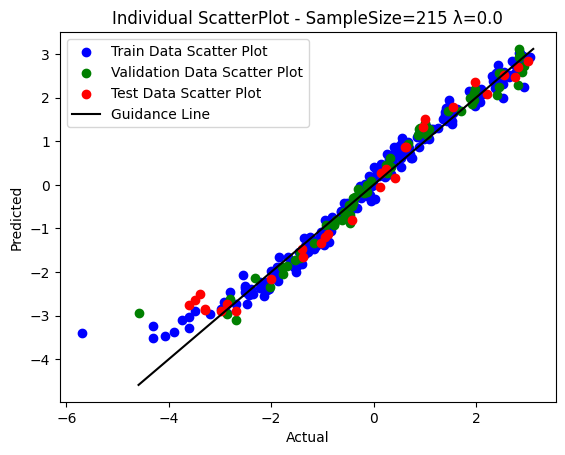

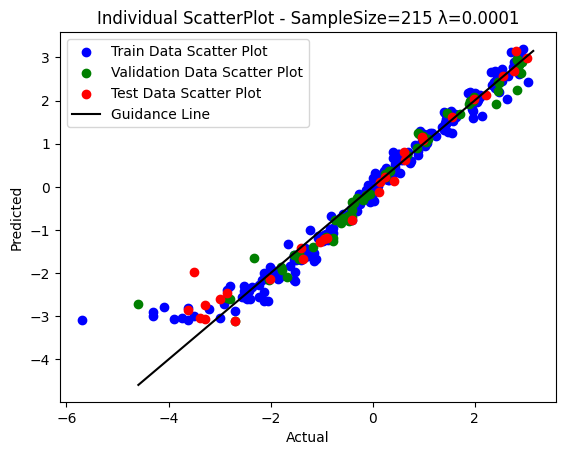

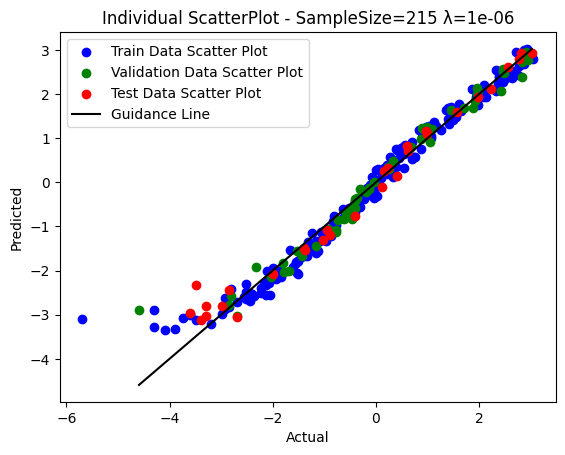

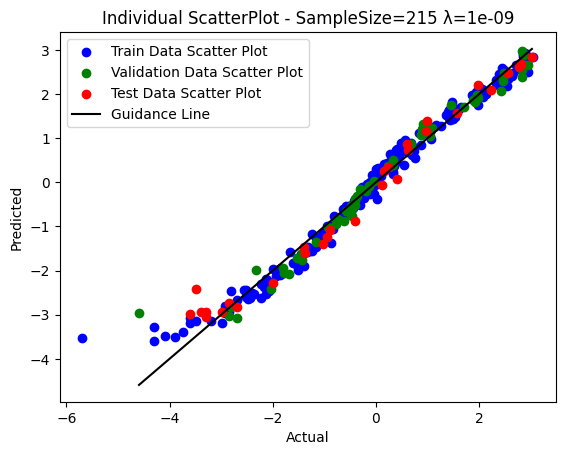

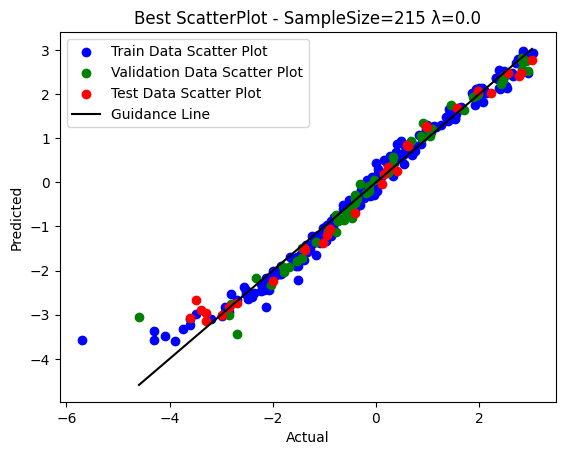

Index Sample Size            λ  Train Erms  Validate Erms  Test Erms
    1         215 0.000000e+00    0.244128       0.293655   0.292776
    2         215 1.000000e-04    0.341226       0.335865   0.404787
    3         215 1.000000e-06    0.309420       0.290105   0.322346
    4         215 1.000000e-09    0.272231       0.263470   0.312435


In [2]:
"""
Task 3. Dataset 3 
    Input -
        Datasets_for_A1 folder needs to be in the current working 
        directory with the folder structure as 
        Datasets_for_A1/Regression/Dataset 3/<team number>/
        Replace <team number> with the actual number.
        e.g. Datasets_for_A1/Regression/Dataset 3/9/
    Output -
        Linear model for regression using Gaussian basis functions for Datasets 2 and 3
        Regularization methods:
            1. No regularization
            2. Quadratic regularization
        Presentation of Results:
            • Scatter plots with target output on x-axis and model output on y-axis 
            for the best performing model, for training data and test data.
            • Tables showing the 𝐸𝑅𝑀𝑆 on the training data, the validation
            data and the test data, for different models.
"""

import os
import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

lambda_string = "λ"
column_names = [
    "Index",
    "Sample Size",
    "λ",
    "Train Erms",
    "Validate Erms",
    "Test Erms",
]
table_index = 0
table_df = pd.DataFrame(columns=column_names)


def add_data_to_table(sample_size, lamda, train_erms, validate_erms, test_erms):
    row_data = {}
    global table_df
    global table_index
    table_index = table_index + 1
    row_data["Index"] = table_index
    row_data["Sample Size"] = sample_size
    row_data["λ"] = lamda
    row_data["Train Erms"] = train_erms
    row_data["Validate Erms"] = validate_erms
    row_data["Test Erms"] = test_erms
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        table_df = pd.concat(
            [table_df, pd.DataFrame(row_data, index=[0])], ignore_index=True
        )


def print_table():
    print(table_df.to_string(index=False))


def get_N(x):
    N = len(x)
    return N


def get_identity_matrix(n):
    identity_matrix = np.eye(n)

    return identity_matrix


def estimate_sigma(x, centroids):
    sigma_list = []
    data = x
    N = data.shape[0]
    for loop in range(N):
        small_phi = []
        data_x = data[loop]
        for centroid in centroids:
            sum = np.square(np.linalg.norm(data_x - centroid, 2))
            sigma_list.append(sum)
    sigma_avg = np.average(sigma_list)

    return sigma_avg


def get_phi_by_gaussian(x, D):
    data = x
    cluster_count = D - 1

    indices = list(range(data.shape[0]))
    random.shuffle(indices)
    centroid_indices = indices[:cluster_count]
    centroid_indices = np.array(centroid_indices)

    centroids = data[centroid_indices]

    cluster_members = [[] for _ in range(cluster_count)]

    while True:
        distances = np.empty((data.shape[0], centroids.shape[0]))
        for i, point in enumerate(data):
            for j, centroid in enumerate(centroids):
                distance = np.linalg.norm(point - centroid, 2)
                distances[i, j] = distance

        labels = []

        for row in distances:
            min_distance = float("inf")
            min_index = -1
            for i, distance in enumerate(row):
                if distance < min_distance:
                    min_distance = distance
                    min_index = i
            labels.append(min_index)

        labels = np.array(labels)

        new_centroids = []

        for k in range(cluster_count):
            cluster_points = data[labels == k]
            if cluster_points.size == 0:
                centroids = np.array([])
                return centroids
            centroid = cluster_points.mean(axis=0)
            new_centroids.append(centroid)

        new_centroids = np.array(new_centroids)

        cluster_members = [[] for _ in range(cluster_count)]
        centroid_mapping = {tuple(centroid): [] for centroid in centroids}
        for i, label in enumerate(labels):
            cluster_members[label].append(data[i])
            centroid_mapping[tuple(centroids[label])].append(data[i])

        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids


def get_small_phi(data_x, centroids, sigma):
    small_phi = []
    for centroid in centroids:
        sum = np.square(np.linalg.norm(data_x - centroid, 2))
        sum = sum / sigma
        sum = np.exp(-sum)
        small_phi.append(sum)
    small_phi = np.insert(small_phi, 0, 1)

    return small_phi


def get_big_phi(x, centroids, sigma):

    big_phi = []
    data = x
    N = data.shape[0]
    for loop in range(N):
        data_x = data[loop]
        small_phi = get_small_phi(data_x, centroids, sigma)
        big_phi.append(small_phi)

    np_big_phi = np.array(big_phi)

    return np_big_phi


def get_new_y(w, big_phi, N, D):
    new_y = []
    loop1 = 0

    for loop1 in range(N):
        small_phi = big_phi[loop1]
        y = 0
        loop2 = 0
        for loop2 in range(D):
            wi = w[loop2]
            small_phii = small_phi[loop2]
            y = y + (wi * small_phii)
        new_y.append(y)
    np_new_y = np.array(new_y)
    return np_new_y


def get_erms(y, t):
    loop = 0
    total_data = len(y)
    sum = 0

    for loop in range(total_data):
        sum = sum + np.square(y[loop] - t[loop])

    error = sum / total_data

    erms = np.sqrt(error)

    return erms


def scatter_plot_2d(x, y, x_label, y_label, plot_title, plot_color):
    plt.scatter(x, y, color=plot_color, label=plot_title)
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    # plt.show()


def line_plot(x, y, plot_label, plot_color):
    plt.plot(x, y, color=plot_color, label=plot_label)
    plt.legend()
    # plt.show()


def get_least_erms(n):
    global table_df
    last_n_rows = table_df.tail(n)
    sorted_rows = last_n_rows.sort_values(by="Test Erms")
    first_sorted_row_values = sorted_rows.iloc[0].values
    return first_sorted_row_values


def plot_scatter(
    sample_size, lamda, train_x, train_y, val_x, val_y, test_x, test_y, title
):
    N = get_N(train_y)
    D = N * 0.2
    D = int(D)

    while True:
        centroids = get_phi_by_gaussian(train_x, D)
        if centroids.size != 0:
            break

    sigma = estimate_sigma(train_x, centroids)

    big_phi_train = get_big_phi(train_x, centroids, sigma)
    w = my_polyfit(big_phi_train, train_y, D, lamda)
    new_train_y = get_new_y(w, big_phi_train, N, D)
    plot_title = "Train Data Scatter Plot"
    scatter_plot_2d(train_y, new_train_y, "Actual", "Predicted", plot_title, "blue")

    N = get_N(val_y)
    big_phi_val = get_big_phi(val_x, centroids, sigma)
    new_val_y = get_new_y(w, big_phi_val, N, D)
    plot_title = "Validation Data Scatter Plot"
    scatter_plot_2d(val_y, new_val_y, "Actual", "Predicted", plot_title, "green")

    N = get_N(test_y)
    big_phi_test = get_big_phi(test_x, centroids, sigma)
    new_test_y = get_new_y(w, big_phi_test, N, D)
    plot_title = "Test Data Scatter Plot"
    scatter_plot_2d(test_y, new_test_y, "Actual", "Predicted", plot_title, "red")

    min_point = min(
        np.min(val_y), np.min(new_val_y), np.min(test_y), np.min(new_test_y)
    )
    max_point = max(
        np.max(val_y), np.max(new_val_y), np.max(test_y), np.max(new_test_y)
    )

    line_plot((min_point, max_point), (min_point, max_point), "Guidance Line", "black")

    plot_title = (
        title + "ScatterPlot - SampleSize=" + str(sample_size) + " λ=" + str(lamda)
    )
    plt.title(plot_title)
    current_directory = os.getcwd()
    os.makedirs(current_directory + "/reg_3", exist_ok=True)
    plt.savefig(current_directory + "/reg_3/" + plot_title + ".png")
    plt.show()


def my_pseudo_inverse(matrix):
    matrix_transpose = np.transpose(matrix)
    phi_trans_multi_phi = np.dot(matrix_transpose, matrix)
    phi_trans_multi_phi_inv = np.linalg.inv(phi_trans_multi_phi)
    phi_trans_multi_phi_inv_multi_phi_trans = np.dot(
        phi_trans_multi_phi_inv, matrix_transpose
    )

    return phi_trans_multi_phi_inv_multi_phi_trans


def my_pseudo_inverse_with_regularization(matrix, matrix_dimension, lamda):
    matrix_transpose = np.transpose(matrix)
    phi_trans_multi_phi = np.dot(matrix_transpose, matrix)
    Identity = get_identity_matrix(matrix_dimension)
    regularization_matrix = np.multiply(Identity, lamda)
    phi_trans_multi_phi_add_regularized = np.add(
        phi_trans_multi_phi, regularization_matrix
    )
    phi_trans_multi_phi_inv = np.linalg.inv(phi_trans_multi_phi_add_regularized)
    phi_trans_multi_phi_inv_multi_phi_trans = np.dot(
        phi_trans_multi_phi_inv, matrix_transpose
    )

    return phi_trans_multi_phi_inv_multi_phi_trans


def my_polyfit(big_phi, y, D, lamda=0.0):
    if lamda == 0.0:
        my_pseudo_inv_np_big_phi = my_pseudo_inverse(big_phi)
        pseudo_inv_np_big_phi = my_pseudo_inv_np_big_phi
    else:
        my_regularized_pseudo_inv_np_big_phi = my_pseudo_inverse_with_regularization(
            big_phi, D, lamda
        )
        pseudo_inv_np_big_phi = my_regularized_pseudo_inv_np_big_phi

    w = np.dot(pseudo_inv_np_big_phi, y)

    return w


def plot_graphs(train_x, train_y, title, val_x, val_y, test_x, test_y, lamda=0.0):
    N = get_N(train_y)
    sample_size = N
    D = N * 0.2
    D = int(D)

    while True:
        centroids = get_phi_by_gaussian(train_x, D)
        if centroids.size != 0:
            break

    sigma = estimate_sigma(train_x, centroids)
    big_phi_train = get_big_phi(train_x, centroids, sigma)
    w = my_polyfit(big_phi_train, train_y, D, lamda)

    new_train_y = get_new_y(w, big_phi_train, N, D)
    train_erms = get_erms(new_train_y, train_y)

    N = get_N(val_y)
    big_phi_val = get_big_phi(val_x, centroids, sigma)
    new_val_y = get_new_y(w, big_phi_val, N, D)
    validate_erms = get_erms(new_val_y, val_y)

    N = get_N(test_y)
    big_phi_test = get_big_phi(test_x, centroids, sigma)
    new_test_y = get_new_y(w, big_phi_test, N, D)
    test_erms = get_erms(new_test_y, test_y)

    add_data_to_table(sample_size, lamda, train_erms, validate_erms, test_erms)

    min_erms = get_least_erms(1)
    plot_scatter(
        min_erms[1],
        min_erms[2],
        train_x,
        train_y,
        val_x,
        val_y,
        test_x,
        test_y,
        "Individual ",
    )


def main():
    folder_number = "18"
    current_directory = os.getcwd()
    regression_dataset_3_path = (
        current_directory
        + "/Datasets_for_A1/Regression/Dataset 3/"
        + folder_number
        + "/"
    )

    regression_dataset_3_Train_data = regression_dataset_3_path + "train_data.csv"
    df = pd.read_csv(regression_dataset_3_Train_data)
    data = df.to_numpy()
    train_x = data

    regression_dataset_3_Train_label = regression_dataset_3_path + "train_label.csv"
    df = pd.read_csv(regression_dataset_3_Train_label)
    data = df.to_numpy()
    train_y = data

    regression_dataset_3_Validation_data = regression_dataset_3_path + "val_data.csv"
    df = pd.read_csv(regression_dataset_3_Validation_data)
    data = df.to_numpy()
    val_x = data

    regression_dataset_3_Validation_label = regression_dataset_3_path + "val_label.csv"
    df = pd.read_csv(regression_dataset_3_Validation_label)
    data = df.to_numpy()
    val_y = data

    regression_dataset_3_Test_data = regression_dataset_3_path + "test_data.csv"
    df = pd.read_csv(regression_dataset_3_Test_data)
    data = df.to_numpy()
    test_x = data

    regression_dataset_3_Test_label = regression_dataset_3_path + "test_label.csv"
    df = pd.read_csv(regression_dataset_3_Test_label)
    data = df.to_numpy()
    test_y = data

    regularization_coefficients = [0.0, 0.0001, 1e-6, 1e-9]

    for lamda in regularization_coefficients:
        plot_graphs(
            train_x,
            train_y,
            "real world data",
            val_x,
            val_y,
            test_x,
            test_y,
            lamda,
        )

    min_erms = get_least_erms(len(regularization_coefficients))
    plot_scatter(
        min_erms[1],
        min_erms[2],
        train_x,
        train_y,
        val_x,
        val_y,
        test_x,
        test_y,
        "Best ",
    )

    print_table()


if __name__ == "__main__":
    main()